In [1]:
!pip install medmnist
!pip install radiomics
!pip install pyradiomics
!pip install ipyvolume


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.0 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

In [2]:
import sys
import os

import medmnist
from medmnist import INFO, Evaluator, PneumoniaMNIST

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.distributions import Normal, kl_divergence


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import radiomics
import SimpleITK as sitk
from radiomics import firstorder, shape2D

import random
import numpy as np
import pandas as pd

from google.colab import drive


from skimage.filters import threshold_otsu

import matplotlib.pyplot as plt
import ipyvolume as ipv

In [3]:
# Définir un chemin pour le dossier
from google.colab import drive
import os
import sys

save_dir = '/content/drive/MyDrive/PETvCLIN/'

In [4]:
drive.mount('/content/drive', force_remount=True)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)  # Crée le dossier s'il n'existe pas

sys.path.append(save_dir + '2D')

Mounted at /content/drive


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
from c_vae import ContrastiveVAE
from medmnist_hcr import MedMNISTwHCR
from train_model import TrainModel
from cnn_model import Classifier, FactorClassifier

In [7]:
import tensorflow as tf
import torch

! export CUDA_LAUNCH_BLOCKING=1


torch.cuda.empty_cache()
tf.test.gpu_device_name()

'/device:GPU:0'

In [8]:


# Utilisation
data_flag = 'pneumoniamnist'

hcr_folder = save_dir + 'hcr_features' + '_' + data_flag
# Préparer les transformations et chargement des données

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

#train dataset
train_ds = MedMNISTwHCR(data_flag = data_flag, split= 'train', transform=transform, size=64, hcr_folder= hcr_folder)
train_loader = DataLoader(train_ds, batch_size=100, shuffle=True)

#validation dataset
validation_ds = MedMNISTwHCR(data_flag = data_flag, split= 'val', transform=transform, size=64, hcr_folder= hcr_folder)
validation_loader = DataLoader(validation_ds, batch_size=32, shuffle=True)

#test dataset
test_ds = MedMNISTwHCR(data_flag = data_flag, split= 'test', transform=transform, size=64, hcr_folder= hcr_folder)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True)




100%|██████████| 20.6M/20.6M [00:00<00:00, 66.3MB/s]


In [9]:
# hyper-parameter

hyperparams = {

    "learning_rate" : 1e-4,

    "factor_learning_rate" :1e-5,

    "alpha": 1 ,  # Paramètres de régularisation L2

    "beta_c": 1.19*1e-2,  # Poids de la divergence de KL entre la distribution latente des DLR et d'une loi normale centrée réduite

    "kappa": 50, # Poids de l'erreur mutuelle information provenant du factor_classifier

    "gamma": 1,  # Poids de l'erreur de classification dans l'entraînement du C-VAE

    "fader_param": 1e-3,

    "reconstruction_param" : 1,

    "dlr_size": 32,

    "hcr_size": 10,

    "epochs":75,


}




In [10]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [11]:
vae = ContrastiveVAE(hyperparams=hyperparams)


# Sauvegarde d'une copie des paramètres avant entraînement
params_before = {k: v.clone() for k, v in vae.state_dict().items()}


trainer = TrainModel(hyperparams=hyperparams, model=vae )

trainer.train(train_loader=train_loader)


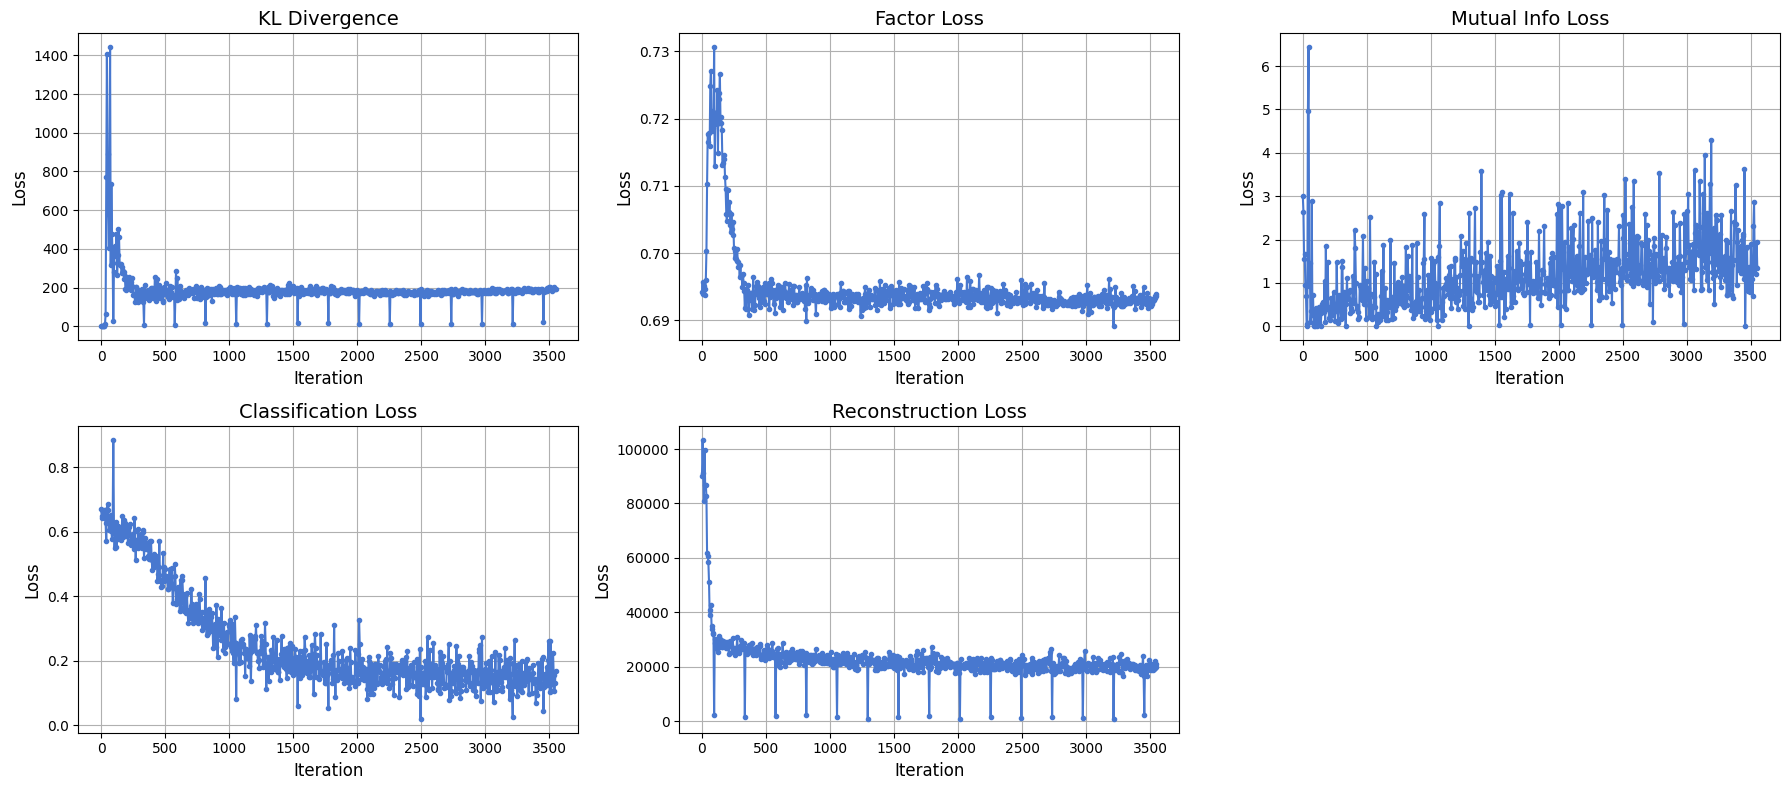

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
import matplotlib.pyplot as plt
import numpy as np

KL_loss_list = np.array(trainer.KL_loss_list)
factor_loss = np.array( trainer.factor_loss_list )
MI_loss_list = np.array(trainer.MI_loss_list)
classif_loss_list = np.array(trainer.classif_loss_list)
reconstruction = np.array(trainer.reconstruction_loss_list)



step = 5
idxs = np.array([1 if i % step == 0 else 0 for i in range(len(KL_loss_list))])
idxs_bool = idxs == 1

kl = KL_loss_list[idxs_bool]
factor = factor_loss[idxs_bool]
mi = MI_loss_list[idxs_bool]
clsf = classif_loss_list[idxs_bool]
recons = reconstruction[idxs_bool]
epochs = np.arange(len(KL_loss_list))[idxs_bool]

plt.style.use("seaborn-v0_8-muted")

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

titles = ["KL Divergence", "Factor Loss", "Mutual Info Loss", "Classification Loss", "Reconstruction Loss"]
values = [kl, factor, mi, clsf, recons]

for i in range(5):
    axes[i].plot(epochs, values[i], marker="o", markersize=3, linewidth=1.5)
    axes[i].set_title(titles[i], fontsize=14)
    axes[i].set_xlabel("Iteration", fontsize=12)
    axes[i].set_ylabel("Loss", fontsize=12)
    axes[i].grid(True)

fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig("loss_plots.png", dpi=150)
plt.show()

from google.colab import files
files.download("loss_plots.png")



In [14]:
tester = TestModel2(trainer=trainer)


TEST B-ACC :  0.6226166995397766
TEST FACTOR B-ACC :  0.5
Linear probe trained space latent, latents HCR + DLR :  0.8285256410256411


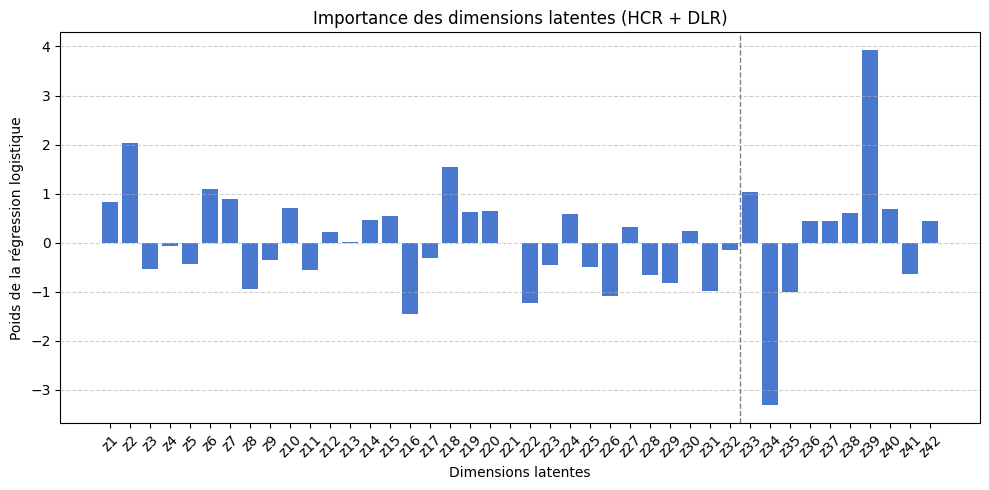

Linear probe trained space original, latents HCR + DLR :  0.8333333333333334
Linear probe trained, latents HCR + DLR (SVM) :  0.7548076923076923


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Linear probe trained, latents HCR + DLR (Random forest) :  0.8141025641025641
Variance expliquée du PCA sur les données latentes: [0.2743538  0.17199083]
Variance du PCA du sur les données initiales : [0.38265646 0.10186529]
(4708, 1)


<Figure size 640x480 with 0 Axes>

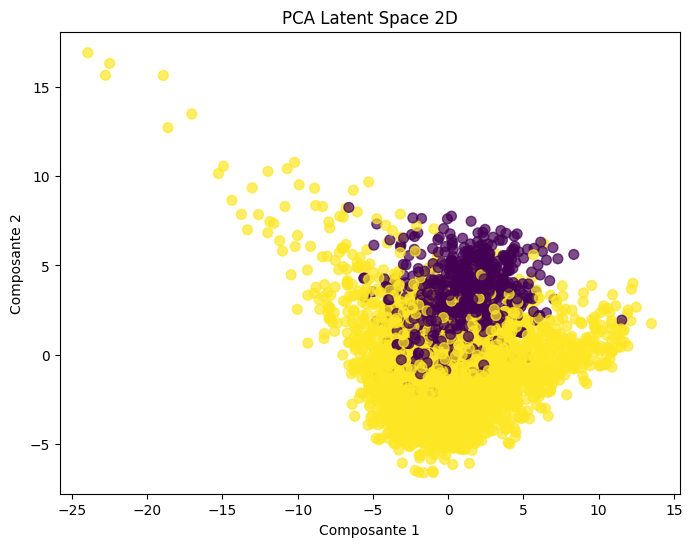

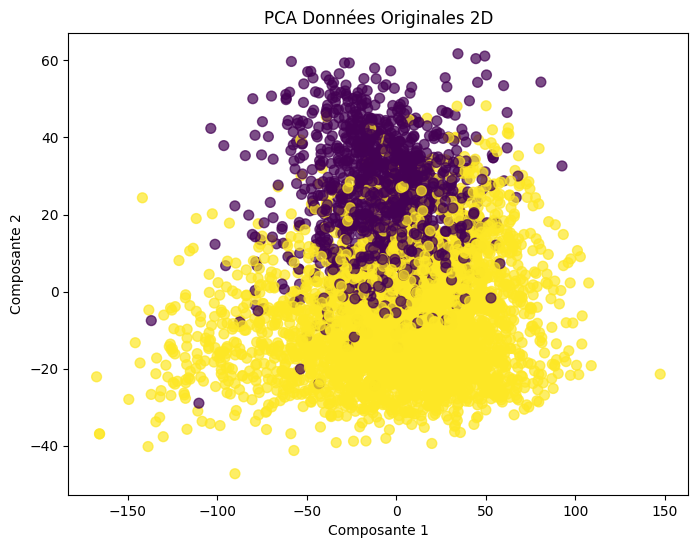

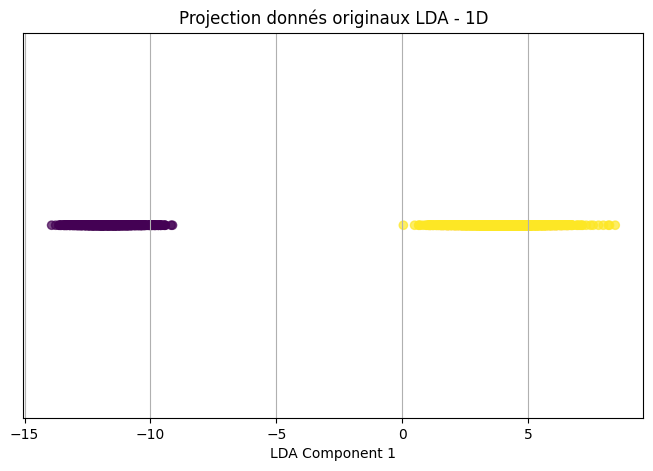

(4708, 1)


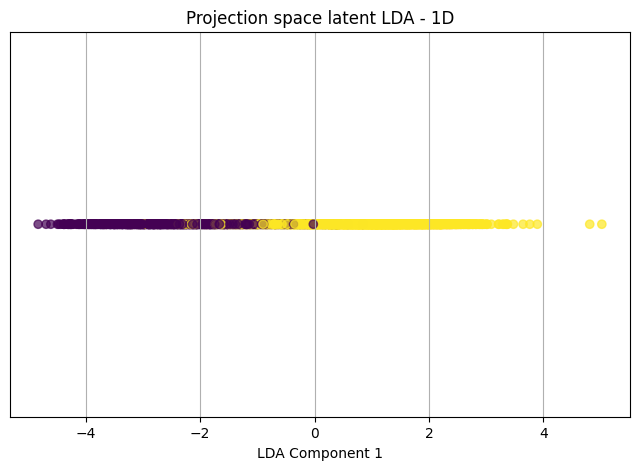

In [15]:
tester.test(test_loader=test_loader)
tester.test_linear_probe(test_loader = test_loader, train_loader = train_loader )

tensor([0])


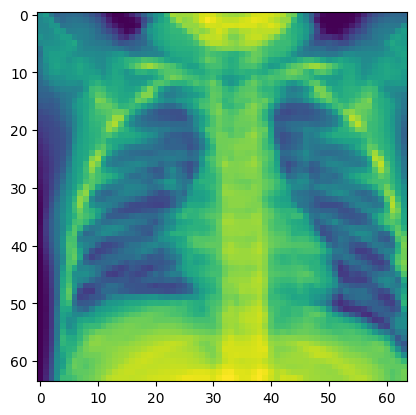

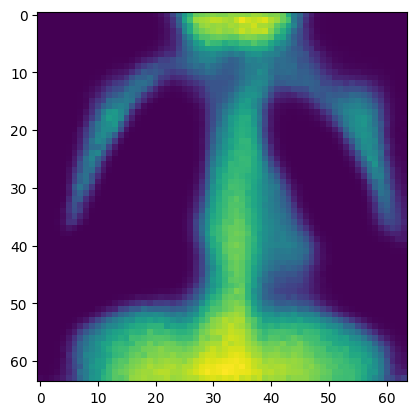

In [16]:
for data, target, hcr in train_loader:
    data = data.cuda()

    reconstructed_z, z, z_mean, z_log_var, y_pred  = vae.inference(data, hcr)

    print(target[0])
    plt.figure()
    plt.imshow(data.cpu().detach()[0][0])
    plt.figure(    )
    plt.imshow(reconstructed_z.cpu().detach()[0][0])

    break